In [1]:
try:
    sc.stop()
except:
    pass


1. start a spark context and sparksession 

In [2]:
from pyspark import SparkConf,SparkContext
from pyspark.streaming import StreamingContext

In [3]:
config = SparkConf().setMaster("local[2]").setAppName("sparkSession")
sc= SparkContext(conf = config)

In [4]:
spark = SparkSession.builder.appName("sparkSession").getOrCreate()

In [5]:
spark

In [6]:
churn_df=spark.read.csv("file:///home/hadoop/Downloads/churn-bigml-80.csv",header=True,inferSchema=True)

In [7]:
churn_df.show(5)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|   

In [8]:
print(churn_df.columns)

['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']


In [9]:
churn_df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



### 3. Data manipulation
    * check for null values

In [10]:
from pyspark.sql.functions import col,isnull,count,when
churn_df.select([count(when(isnull(column), column)).alias(column) for column in churn_df.columns]).toPandas()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 4. Data Preprocssing

In [11]:
from pyspark.sql.functions import *


In [12]:
churn_df = churn_df.withColumn('Churn', regexp_replace('Churn', 'false', '0'))
churn_df = churn_df.withColumn('Churn', regexp_replace('Churn', 'true', '1'))


In [13]:
churn_df = churn_df.withColumn('International plan', regexp_replace('International plan', 'Yes', '1'))
churn_df = churn_df.withColumn('International plan', regexp_replace('International plan', 'No', '0'))

In [14]:
churn_df = churn_df.withColumn('Voice mail plan', regexp_replace('Voice mail plan', 'Yes', '1'))
churn_df = churn_df.withColumn('Voice mail plan', regexp_replace('Voice mail plan', 'No', '0'))

 Typecasting all columns - 'churn','Voice mail plan','International plan',

In [15]:
from pyspark.sql.types import *
churn_df =churn_df.withColumn('Churn',col('Churn').cast(IntegerType()))
churn_df =churn_df.withColumn('International plan',col('International plan').cast(IntegerType()))
churn_df =churn_df.withColumn('Voice mail plan',col('Voice mail plan').cast(IntegerType()))

### 4. Features and Target 

In [16]:
churn_df1  = churn_df.drop('State','Account length')

In [17]:
churn_df1.columns


['Area code',
 'International plan',
 'Voice mail plan',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve calls',
 'Total eve charge',
 'Total night minutes',
 'Total night calls',
 'Total night charge',
 'Total intl minutes',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls',
 'Churn']

In [18]:
from pyspark.mllib.stat import Statistics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# result can be used w/ seaborn's heatmap
def compute_correlation_matrix(df, method='pearson'):
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

In [19]:
compute_correlation_matrix(churn_df1)

,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
Area code,1.000000,0.047099,0.007180,-0.000584,-0.023134,-0.009629,-0.023130,0.000679,-0.018602,0.000707,-0.003353,0.011455,-0.003382,-0.013418,-0.027423,-0.013534,0.034442,0.001019
International plan,0.047099,1.000000,0.002131,0.005858,0.049550,-0.004277,0.049555,0.026616,0.010277,0.026623,-0.010310,0.018081,-0.010316,0.053162,0.011549,0.053037,-0.035955,0.277489
Voice mail plan,0.007180,0.002131,1.000000,0.957159,0.013438,-0.007541,0.013439,0.019132,0.003404,0.019147,0.001065,0.013985,0.001066,-0.013963,0.015196,-0.013931,-0.022054,-0.099291
Number vmail messages,-0.000584,0.005858,0.957159,1.000000,0.019027,-0.009622,0.019027,0.011401,0.005131,0.011418,-0.000224,0.008124,-0.000229,-0.004156,0.027013,-0.004136,-0.018787,-0.086474
Total day minutes,-0.023134,0.049550,0.013438,0.019027,1.000000,0.016780,1.000000,0.003999,0.009059,0.003992,0.013491,0.015054,0.013464,-0.011042,0.005687,-0.010934,-0.024543,0.195688
Total day calls,-0.009629,-0.004277,-0.007541,-0.009622,0.016780,1.000000,0.016787,-0.026003,0.006473,-0.026006,0.008986,-0.016776,0.008972,0.031036,0.006928,0.031133,-0.011945,0.018290
Total day charge,-0.023130,0.049555,0.013439,0.019027,1.000000,0.016787,1.000000,0.004008,0.009056,0.004002,0.013495,0.015057,0.013468,-0.011046,0.005688,-0.010938,-0.024548,0.195689
Total eve minutes,0.000679,0.026616,0.019132,0.011401,0.003999,-0.026003,0.004008,1.000000,-0.007654,1.000000,-0.013414,0.009017,-0.013450,-0.006915,0.002160,-0.006947,-0.013192,0.072906
Total eve calls,-0.018602,0.010277,0.003404,0.005131,0.009059,0.006473,0.009056,-0.007654,1.000000,-0.007642,-0.000175,0.000797,-0.000135,0.011012,0.003710,0.011000,0.001058,-0.001539
Total eve charge,0.000707,0.026623,0.019147,0.011418,0.003992,-0.026006,0.004002,1.000000,-0.007642,1.000000,-0.013428,0.009030,-0.013464,-0.006923,0.002169,-0.006955,-0.013196,0.072893


<AxesSubplot:>

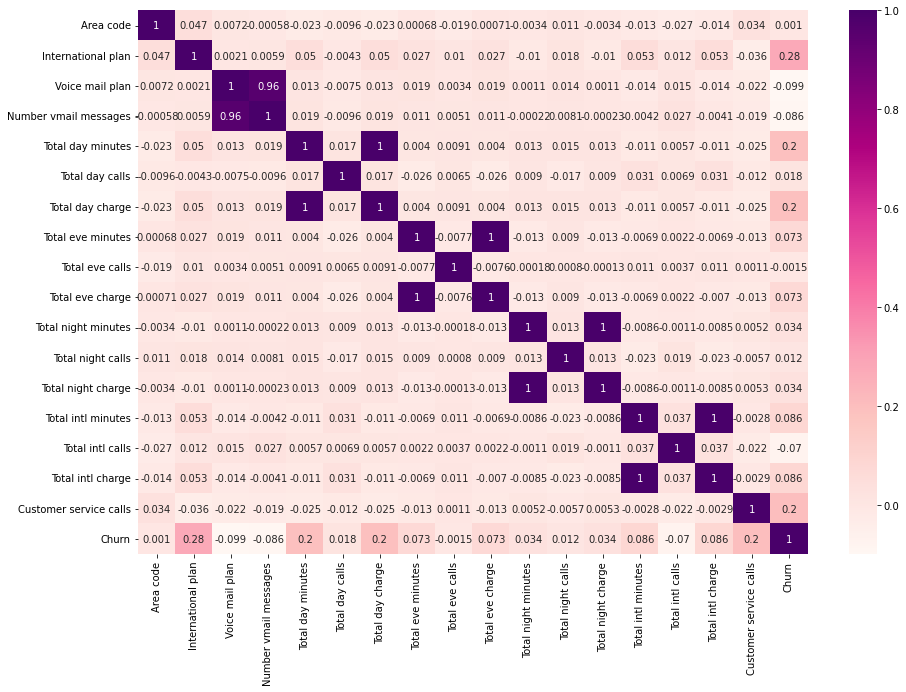

In [20]:
plt.figure(figsize = (15,10))
sns.heatmap(compute_correlation_matrix(churn_df1),annot = True,cmap = 'RdPu')

In [21]:
from pyspark.ml.feature import VectorAssembler

In [22]:
vectorassembler = VectorAssembler(inputCols=[
 'Area code',
 'International plan',
 'Voice mail plan',
 'Total day minutes',
 'Total day calls',
 'Total eve minutes',
 'Total eve calls',
 'Total night minutes',
 'Total night calls',
 'Total intl minutes',
 'Total intl calls',
 'Customer service calls',
], outputCol= 'features')

In [23]:
churn_df1=vectorassembler.transform(churn_df)
churn_df1.select("features").show(truncate=False)

+----------------------------------------------------------------+
|features                                                        |
+----------------------------------------------------------------+
|[415.0,0.0,1.0,265.1,110.0,197.4,99.0,244.7,91.0,10.0,3.0,1.0]  |
|[415.0,0.0,1.0,161.6,123.0,195.5,103.0,254.4,103.0,13.7,3.0,1.0]|
|[415.0,0.0,0.0,243.4,114.0,121.2,110.0,162.6,104.0,12.2,5.0,0.0]|
|[408.0,1.0,0.0,299.4,71.0,61.9,88.0,196.9,89.0,6.6,7.0,2.0]     |
|[415.0,1.0,0.0,166.7,113.0,148.3,122.0,186.9,121.0,10.1,3.0,3.0]|
|[510.0,1.0,0.0,223.4,98.0,220.6,101.0,203.9,118.0,6.3,6.0,0.0]  |
|[510.0,0.0,1.0,218.2,88.0,348.5,108.0,212.6,118.0,7.5,7.0,3.0]  |
|[415.0,1.0,0.0,157.0,79.0,103.1,94.0,211.8,96.0,7.1,6.0,0.0]    |
|[415.0,1.0,1.0,258.6,84.0,222.0,111.0,326.4,97.0,11.2,5.0,0.0]  |
|[415.0,0.0,0.0,187.7,127.0,163.4,148.0,196.0,94.0,9.1,5.0,0.0]  |
|[408.0,0.0,0.0,128.8,96.0,104.9,71.0,141.1,128.0,11.2,2.0,1.0]  |
|[510.0,0.0,0.0,156.6,88.0,247.6,75.0,192.3,115.0,12.3,5.0,3.0

In [24]:
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
churn_df1=standardscaler.fit(churn_df1).transform(churn_df1)
churn_df1.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[415.0,0.0,1.0,26...|[9.75987921574203...|
|[415.0,0.0,1.0,16...|[9.75987921574203...|
|[415.0,0.0,0.0,24...|[9.75987921574203...|
|[408.0,1.0,0.0,29...|[9.59525474704277...|
|[415.0,1.0,0.0,16...|[9.75987921574203...|
+--------------------+--------------------+
only showing top 5 rows



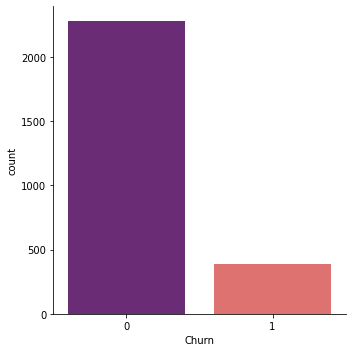

In [25]:
import seaborn as sns
sns.catplot(x = 'Churn', kind = 'count', data = churn_df1.toPandas(), palette='magma')

In [26]:
train, test = churn_df1.randomSplit([0.8, 0.2], seed=2)

In [27]:
# from pyspark.ml.classification import LogisticRegression
# # lr = LogisticRegression().setWeightCol("classWeights").setLabelCol("Outcome").setFeaturesCol("Aspect")
# lr = LogisticRegression(labelCol="Churn", featuresCol="features",maxIter=10)
# model=lr.fit(train)
# predict_train=model.transform(train)
# predict_test=model.transform(test)
# predict_test.select("Churn","prediction").show(10)

+-----+----------+
|Churn|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows



In [35]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="Churn",
                        featuresCol="features")
model=rf.fit(train)
# Prediction Train
predict_train=model.transform(train)
# Prediction Test
predict_test=model.transform(test)
predict_test.select("Churn","prediction").show(10)

+-----+----------+
|Churn|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows



In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="Churn")

In [37]:
predict_test.select("Churn","rawPrediction","prediction","probability").show(5)

+-----+--------------------+----------+--------------------+
|Churn|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[18.7759740581259...|       0.0|[0.93879870290629...|
|    0|[18.6914602435466...|       0.0|[0.93457301217733...|
|    0|[18.6974108627951...|       0.0|[0.93487054313975...|
|    0|[18.8687265415696...|       0.0|[0.94343632707848...|
|    0|[14.8036545255369...|       0.0|[0.74018272627684...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Churn", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predict_test)
print("Accuracy: ",(accuracy))

Accuracy:  0.9421965317919075


In [39]:
#!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable


In [40]:
from sklearn.metrics import confusion_matrix

y_true = predict_test.select("Churn")
y_true = y_true.toPandas()

y_pred = predict_test.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[446,   2],
       [ 28,  43]])

<AxesSubplot:>

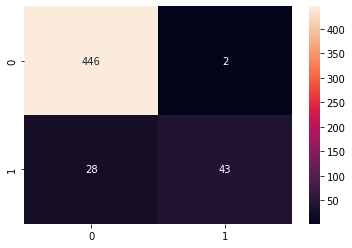

In [41]:
sns.heatmap(cnf_matrix, annot = True, fmt='0.0f')

In [42]:
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set is 0.9464368886818817
The area under ROC for test set is 0.9421965317919075
